In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import cross_val_score

%matplotlib inline

sns.set_palette('coolwarm')

In [7]:
df_raw = pd.read_csv('..//winequality-red.csv', sep=';')
df_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


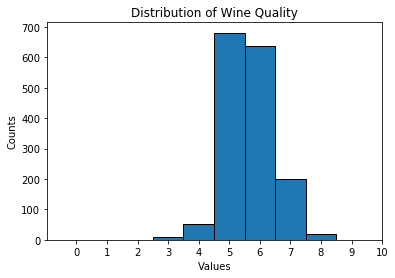

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

In [31]:
plt.hist(df_raw.quality, bins=(np.arange(10)-0.5), edgecolor='black', linewidth=1)
plt.xticks(np.arange(0, 11))
plt.title('Distribution of Wine Quality')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()

df_raw.quality.describe()

In [32]:
# Make a copy of the data to add jitter to and plot.
df_jittered = df_raw.dropna()
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

c:\users\bretw\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


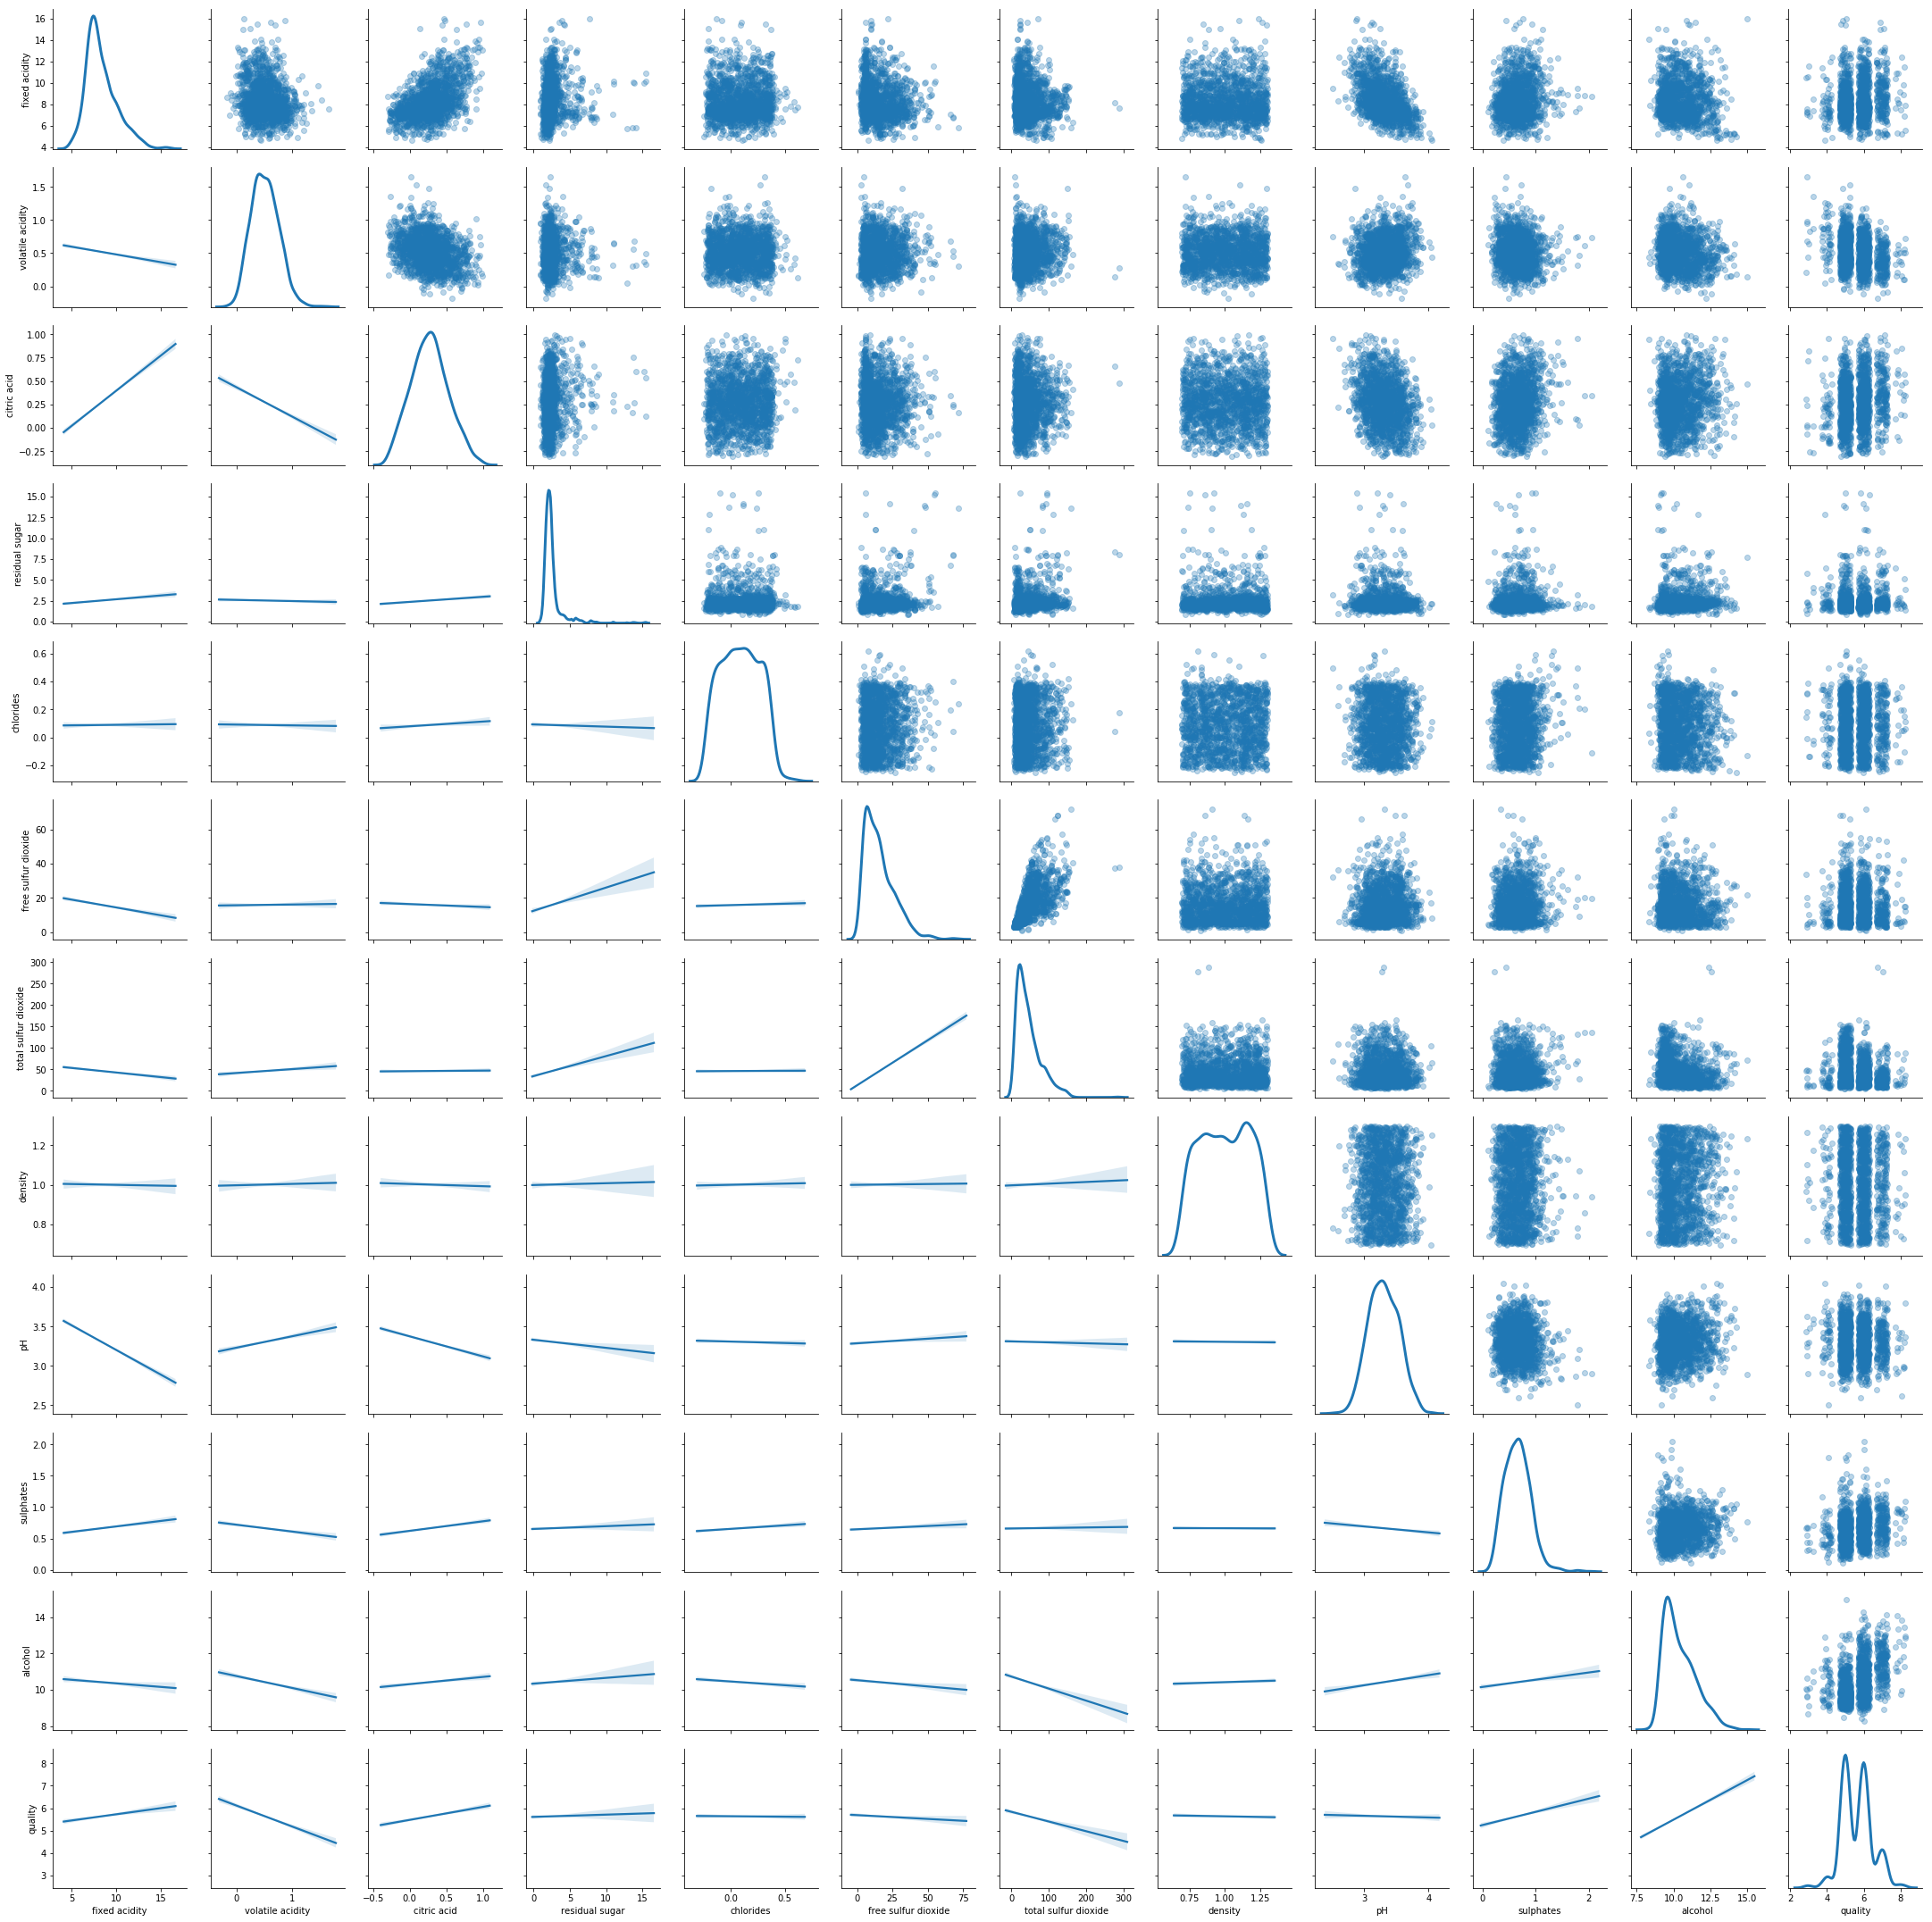

In [39]:
# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.3)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

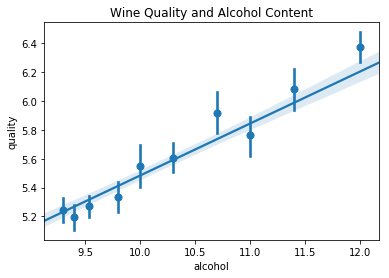

In [45]:
sns.regplot('alcohol', 'quality', data=df_raw, x_bins=10)
plt.title('Wine Quality and Alcohol Content')
plt.show()

Can't say I disagree with this data... :)

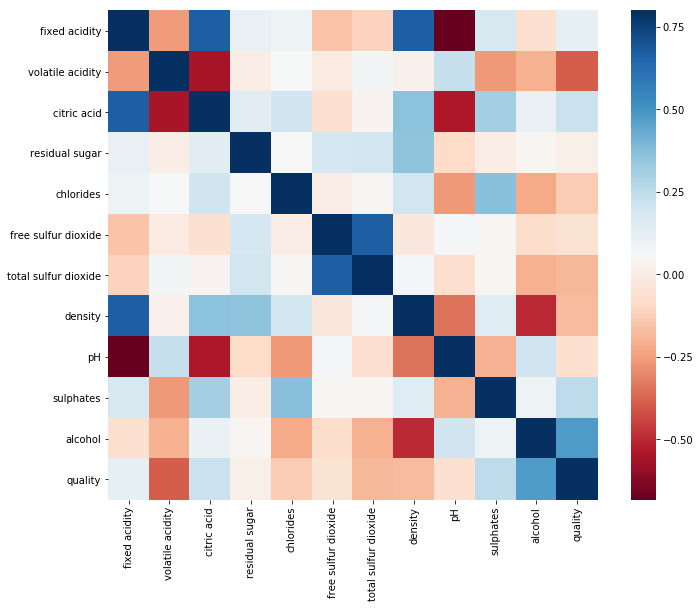

In [62]:
# Make the correlation matrix
corrmat = df_raw.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# I didn't realize how big the PairGrid above was going to be. This will be much more readable/usable
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdBu')
plt.show()

From what I recall, random forests don't really need a whole lot of preprocessing for them to work properly, so let's just drop this in and see what happens.

In [79]:
# Set X and y
X = df_raw.drop('quality', 1)
y = df_raw['quality']

In [85]:
# Initialize Decision Tree. I tried a Regressor first but it did TERRIBLE. Classifier is much better, but not great.
dec_tree = tree.DecisionTreeClassifier(criterion='entropy')

# Start the timer, run it, then print how long it took
start_time = time.time()
print(cross_val_score(dec_tree, X, y, cv=10, n_jobs=-1))
print('--- {0:.3f} seconds ---'.format((time.time() - start_time)))

[ 0.47530864  0.50310559  0.49068323  0.46875     0.49375     0.44375     0.5
  0.53125     0.47468354  0.42038217]
--- 8.388 seconds ---


In [89]:
rfc = ensemble.RandomForestClassifier(n_estimators=10000)

# Start the timer, run it, then print how long it took
start_time = time.time()
print(cross_val_score(rfc, X, y, cv=10, n_jobs=-1))
print('--- {0:.3f} seconds ---'.format((time.time() - start_time)))

[ 0.54938272  0.59627329  0.55900621  0.55625     0.5875      0.61875
  0.575       0.5875      0.62025316  0.60509554]
--- 474.403 seconds ---


First of all, I'm really stoked about the n_jobs parameter I found. It seems to have a bigger payback when the n_estimators is higher. For instance, I tried n_estimators=100, and it took 6 seconds. Next, I tried what you see above: 1000 trees, but only 24 seconds. I'm assuming that adding estimators is O(n) complexity, I'll have to ask Katherine.

EDIT: I bumped it up again to see what would happen. I didn't account for the 10 fold cross-validation, so an increase by 10 is actually an increase by 100, although the results above indicate that it took about 200 times as long.

I thought that this decision tree would be a lot stronger than it was, and the random forest also took a really long time to run for a marginal improvement. I realize I did not do any robust hyperparameter tuning, so that could be a possible area of improvement. I just tweaked the n_parameters a few times and that was it.

Additionally, I did _nothing_ in terms of feature preparation. I think that is ok, because random forests can handle that, but I'm curious if there are specific strategies in feature engineering that could have helped. I'm thinking changing continuous variables into categorical like high, medium, or low.